## 1.Environment Setup

In [1]:
# Import thư viện cần thiết
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score

warnings.filterwarnings('ignore')

# Đặt seed để đảm bảo kết quả nhất quán giữa các lần chạy
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
print(f"Seed: {SEED}")

Seed: 42


## 2.Data Processing

In [2]:
# https://drive.google.com/drive/folders/1cMoqIDEgGYDVzv8B7cKp3csxujQ4OFp7?usp=drive_link
!gdown --folder 1cMoqIDEgGYDVzv8B7cKp3csxujQ4OFp7

Retrieving folder contents
Processing file 1-uEgwNEQuXxptpGi3ygyCi7dm3zOdOR7 dt_test.csv
Processing file 1ciaTX6DHr63apY5pP37K-zeP50VHuGwC dt_train.csv
Processing file 1b88sXRS3mTpP2WUE3uxVwIWh3Ew1MDDB dt_val.csv
Processing file 1etvPpYlkdiz_APIsMlK-Lzjuo_bhx2x2 fe_dt_test.csv
Processing file 1WxUV4z2QMV0KZTjL9-c50fQU13Hgt3m7 fe_dt_train.csv
Processing file 1bE9NHVx6eaXW-NkHimdvaPU94BeATEAX fe_dt_val.csv
Processing file 1UUi6bKKrXbq7i1mDLnzB1b0HdZyP5voU fe_test.csv
Processing file 1XNUMiEPAeeNxwFh8Us5ahS1O2UmOiBR- fe_train.csv
Processing file 1xQN3iXp72II_oqEte1nYR6Wd5DZ_BOQw fe_val.csv
Processing file 1zOvFmhdyPgAHkPiVcPy0Bfu2cBrcoTWv raw_test.csv
Processing file 1o9O3hEhZW58dRLHqvIqfCQ9l9TXgsBD_ raw_train.csv
Processing file 1lZ8sBN2lcYwLqnzyPaGCw1z9qIog5Kr0 raw_val.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1-uEgwNEQuXxptpGi3ygyCi7dm3zOdOR7
To: /content/dataset_v3/dt

In [3]:
def read_csv(file_path):
    df = pd.read_csv(file_path)
    display(df.head())

    X = df.drop('target', axis=1)
    y = df['target']
    display(y.value_counts())

    print("Shape df: ", df.shape)
    print("Shape X: ", X.shape)
    print("Shape y: ", y.shape)

    return X, y

### 2.1 Original Dataset

In [5]:
raw_train = pd.read_csv("dataset_v3/raw_train.csv")
raw_val   = pd.read_csv("dataset_v3/raw_val.csv")
raw_test  = pd.read_csv("dataset_v3/raw_test.csv")

In [6]:
X_train, y_train = raw_train.drop("target", axis=1), raw_train["target"]
X_val, y_val     = raw_val.drop("target", axis=1), raw_val["target"]
X_test, y_test   = raw_test.drop("target", axis=1), raw_test["target"]

### 2.2 FE Dataset

In [8]:
fe_train = pd.read_csv("dataset_v3/fe_train.csv")
fe_val   = pd.read_csv("dataset_v3/fe_val.csv")
fe_test  = pd.read_csv("dataset_v3/fe_test.csv")


In [9]:
X_fe_train, y_fe_train = fe_train.drop("target", axis=1), fe_train["target"]
X_fe_val, y_fe_val     = fe_val.drop("target", axis=1), fe_val["target"]
X_fe_test, y_fe_test   = fe_test.drop("target", axis=1), fe_test["target"]

### 2.3 Original + DT Dataset

In [10]:
dt_train = pd.read_csv("dataset_v3/dt_train.csv")
dt_val   = pd.read_csv("dataset_v3/dt_val.csv")
dt_test  = pd.read_csv("dataset_v3/dt_test.csv")

In [11]:
X_dt_train, y_dt_train = dt_train.drop("target", axis=1), dt_train["target"]
X_dt_val, y_dt_val     = dt_val.drop("target", axis=1), dt_val["target"]
X_dt_test, y_dt_test   = dt_test.drop("target", axis=1), dt_test["target"]

### 2.4 FE + DT Dataset

In [12]:
fe_dt_train = pd.read_csv("dataset_v3/fe_dt_train.csv")
fe_dt_val   = pd.read_csv("dataset_v3/fe_dt_val.csv")
fe_dt_test  = pd.read_csv("dataset_v3/fe_dt_test.csv")

In [13]:
X_fe_dt_train, y_fe_dt_train = fe_dt_train.drop("target", axis=1), fe_dt_train["target"]
X_fe_dt_val, y_fe_dt_val     = fe_dt_val.drop("target", axis=1), fe_dt_val["target"]
X_fe_dt_test, y_fe_dt_test   = fe_dt_test.drop("target", axis=1), fe_dt_test["target"]


In [14]:
print("RAW:", X_train.shape, X_val.shape, X_test.shape)
print("FE:", X_fe_train.shape, X_fe_val.shape, X_fe_test.shape)
print("DT:", X_dt_train.shape, X_dt_val.shape, X_dt_test.shape)
print("FE_DT:", X_fe_dt_train.shape, X_fe_dt_val.shape, X_fe_dt_test.shape)

RAW: (242, 13) (30, 13) (31, 13)
FE: (242, 13) (30, 13) (31, 13)
DT: (242, 10) (30, 10) (31, 10)
FE_DT: (242, 10) (30, 10) (31, 10)


## 3.AdaBoost (AB)

In [15]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

def find_optimal_ada(
    X_train, y_train,
    base_max_depth=1, algorithm="SAMME",
    n_estimators_range=range(50, 501, 50),
    cv_splits=3, learning_rate=0.1,
):
    scores = []
    for n in n_estimators_range:
        base_clf = DecisionTreeClassifier(max_depth=base_max_depth, random_state=42)
        ada = AdaBoostClassifier(
            base_estimator=base_clf,
            n_estimators=n,
            learning_rate=learning_rate,
            algorithm=algorithm,
            random_state=42
        )
        cv_score = cross_val_score(ada, X_train, y_train, cv=cv_splits).mean()
        scores.append(cv_score)

    # Lấy n_estimators tốt nhất
    best_idx = scores.index(max(scores))
    best_n = list(n_estimators_range)[best_idx]
    print(f"n_estimators tối ưu (CV): {best_n}")

    # Vẽ biểu đồ chọn n_estimators
    plt.figure(figsize=(10, 6))
    plt.plot(list(n_estimators_range), scores, 'bo-')
    plt.title(f'Chọn n_estimators tối ưu cho AdaBoost (CV={cv_splits}-fold)')
    plt.xlabel('n_estimators')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.show()

    # Train lại với toàn bộ X_train
    best_model = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=base_max_depth, random_state=42),
        n_estimators=best_n,
        learning_rate=learning_rate,
        algorithm=algorithm,
        random_state=42
    )
    best_model.fit(X_train, y_train)

    return best_model, best_n, max(scores)


def evaluate_val_ada(X_train, y_train, X_val, y_val,
                     n_estimators_range=range(50, 501, 50),
                     cv_splits=3, learning_rate=0.1,
                     base_max_depth=1, algorithm="SAMME"):
    print("Tìm n_estimators tối ưu cho AdaBoost...")
    ada_model, best_n, cv_acc = find_optimal_ada(
        X_train, y_train,
        base_max_depth=base_max_depth,
        algorithm=algorithm,
        n_estimators_range=n_estimators_range,
        cv_splits=cv_splits,
        learning_rate=learning_rate,
    )

    # Dự đoán & báo cáo trên validation
    val_pred = ada_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"\nĐộ chính xác AdaBoost trên tập validation: {val_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, val_pred))
    return ada_model, val_acc, {"n_estimators": best_n}


def evaluate_test_ada(ada_model, X_test, y_test):
    test_pred = ada_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print(f"\nĐộ chính xác AdaBoost trên tập test: {test_acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, test_pred))
    return test_acc


### 3.1 AB on Original Dataset

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.5, 1.0]
}

grid = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Lấy best params + model
best_params = grid.best_params_
ada_model = grid.best_estimator_

print("Best Params:", best_params)
print("Best CV Accuracy:", grid.best_score_)

# Đánh giá trên validation
val_acc = accuracy_score(y_val, ada_model.predict(X_val))

# Đánh giá trên test
test_acc = accuracy_score(y_test, ada_model.predict(X_test))

print("Validation Accuracy:", val_acc)
print("Test Accuracy:", test_acc)


Best Params: {'learning_rate': 0.1, 'n_estimators': 50}
Best CV Accuracy: 0.7974279835390946
Validation Accuracy: 0.9666666666666667
Test Accuracy: 0.8064516129032258


### 3.2 AB on FE Dataset

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

def train_adaboost(X_train, y_train, X_val, y_val):
    param_grid = {
        "n_estimators": [50, 100, 200, 300, 500],
        "learning_rate": [0.01, 0.1, 0.5, 1.0]
    }

    grid = GridSearchCV(
        AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),  # ✅ đổi base_estimator -> estimator
            algorithm="SAMME",
            random_state=42
        ),
        param_grid,
        cv=3,
        scoring="accuracy",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    print("Best Params:", best_params)
    print("Best CV Accuracy:", grid.best_score_)

    # --- Validation ---
    val_pred = best_model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print("\nValidation Accuracy:", val_acc)
    print("Classification Report (Validation):")
    print(classification_report(y_val, val_pred))

    return best_model, best_params, val_acc
def evaluate_test(model, X_test, y_test):
  test_pred = model.predict(X_test)
  test_acc = accuracy_score(y_test, test_pred)
  print("\nTest Accuracy:", test_acc)
  print("Classification Report (Test):")
  print(classification_report(y_test, test_pred))
  return test_acc

In [24]:
ada_model, best_params, val_fe_acc = train_adaboost(
    X_fe_train, y_fe_train,
    X_fe_val, y_fe_val
)

test_fe_acc = evaluate_test(ada_model, X_fe_test, y_fe_test)


Best Params: {'learning_rate': 0.1, 'n_estimators': 50}
Best CV Accuracy: 0.7974794238683128

Validation Accuracy: 0.9666666666666667
Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.93      1.00      0.97        14

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Test Accuracy: 0.8064516129032258
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        17
           1       0.79      0.79      0.79        14

    accuracy                           0.81        31
   macro avg       0.80      0.80      0.80        31
weighted avg       0.81      0.81      0.81        31



### 3.3 AB on Original DT Dataset

In [25]:
# --- Train AdaBoost trên dữ liệu DT ---
ada_model, best_params, val_dt_acc = train_adaboost(
    X_dt_train, y_dt_train,
    X_dt_val, y_dt_val
)

# --- Đánh giá trên tập test DT ---
test_dt_acc = evaluate_test(ada_model, X_dt_test, y_dt_test)


Best Params: {'learning_rate': 0.5, 'n_estimators': 50}
Best CV Accuracy: 0.8055555555555555

Validation Accuracy: 0.9666666666666667
Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.93      1.00      0.97        14

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Test Accuracy: 0.8387096774193549
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.80      0.86      0.83        14

    accuracy                           0.84        31
   macro avg       0.84      0.84      0.84        31
weighted avg       0.84      0.84      0.84        31



### 3.4 AB on FE + DT Dataset

In [26]:
# --- Train AdaBoost trên dữ liệu FE+DT ---
ada_model, best_params, val_fe_dt_acc = train_adaboost(
    X_fe_dt_train, y_fe_dt_train,
    X_fe_dt_val, y_fe_dt_val
)

# --- Đánh giá trên tập test FE+DT ---
test_fe_dt_acc = evaluate_test(ada_model, X_fe_dt_test, y_fe_dt_test)


Best Params: {'learning_rate': 1.0, 'n_estimators': 50}
Best CV Accuracy: 0.8016460905349794

Validation Accuracy: 0.9666666666666667
Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.93      1.00      0.97        14

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Test Accuracy: 0.8387096774193549
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        17
           1       0.80      0.86      0.83        14

    accuracy                           0.84        31
   macro avg       0.84      0.84      0.84        31
weighted avg       0.84      0.84      0.84        31



## 4.Result Visualization

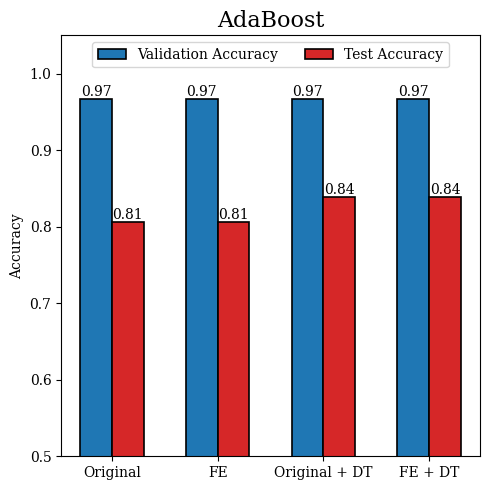

In [27]:
plt.rcParams['font.family'] = 'Serif'

labels = ['Original', 'FE', 'Original + DT', "FE + DT"]
val_accs = [val_acc, val_fe_acc, val_dt_acc, val_fe_dt_acc]
test_accs = [test_acc, test_fe_acc, test_dt_acc, test_fe_dt_acc]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(5, 5))

rects1 = ax.bar(x - width/2, val_accs,  width,
                label='Validation Accuracy',
                color='tab:blue', edgecolor='black', linewidth=1.2)
rects2 = ax.bar(x + width/2, test_accs, width,
                label='Test Accuracy',
                color='tab:red', edgecolor='black', linewidth=1.2)

ax.set_ylim(0.5, 1.05)
ax.set_ylabel('Accuracy')
ax.set_title('AdaBoost', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(ncol=2, loc="upper center")

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.2f}', xy=(rect.get_x()+rect.get_width()/2, h),
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.savefig("accuracy_comparison.png", dpi=300, bbox_inches="tight")
fig.savefig("accuracy_comparison.pdf", bbox_inches="tight")
plt.show()
